Found 30 images belonging to 3 classes.
Found 10 images in class lung_aca
Found 10 images in class lung_n
Found 10 images in class lung_scc
Total images found in training directory: 30


c:\venv\ilumpy-VS\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3333 - loss: 2.8100

c:\venv\ilumpy-VS\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to saved_models/best_model_fold.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3333 - loss: 2.8100 - val_accuracy: 0.3333 - val_loss: 10.0225 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3333 - loss: 9.7243
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3750 - loss: 1.3877
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to saved_models/best_model_fold.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3750 - loss: 1.3877 - val_accuracy: 0.5000 - val_loss: 2.0854 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5000 - loss: 2.0504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3750 - loss: 2.2616
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to saved_models/best_model_fold.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3750 - loss: 2.2616 - val_accuracy: 0.1667 - val_loss: 6.7734 - learning_rate: 0

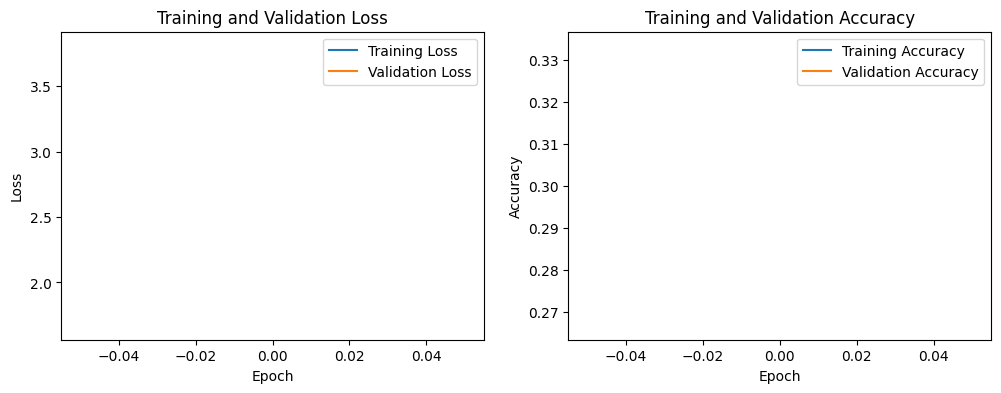

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


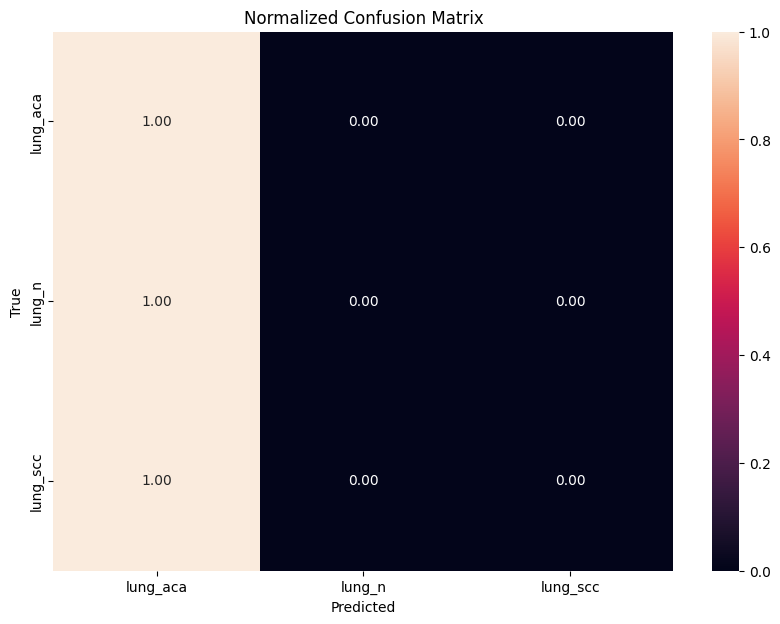

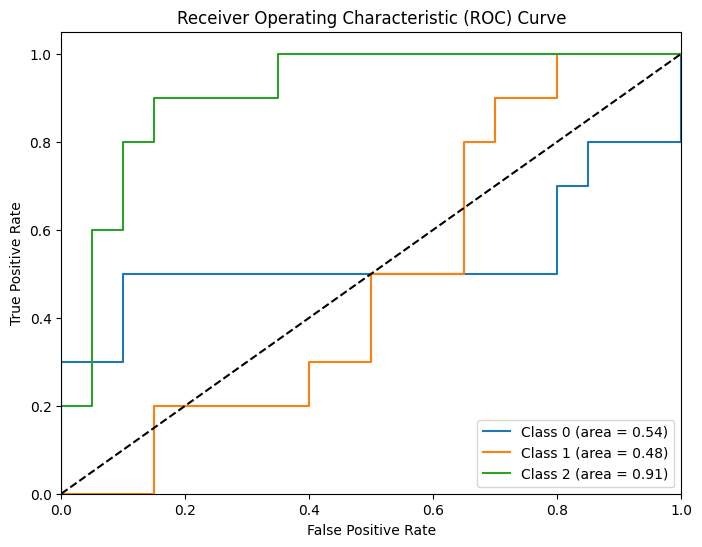

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
import os
import logging

# Ensure the necessary directories exist
os.makedirs('saved_models', exist_ok=True)
os.makedirs('saved_logs', exist_ok=True)

# Set random seeds for reproducibility
EPOCHS = 1
RANDOM_SEED = 1024

# Hyperparameters
drop = 0.25
kernel_initializer = 'he_uniform'
optimizer = 'Adam'

# Set up the directories
train_dir = "../../Images_data/training_set_reduced"
test_dir = "../../Images_data/test_set_reduced"

# Set up logging
logging.basicConfig(filename='training_log.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Save hyperparameters
with open('hyperparameters.txt', 'w') as f:
    f.write(f"Epochs: {EPOCHS}\n")
    f.write(f"Optimizer: {optimizer}\n")
    f.write(f"Kernel Initializer: {kernel_initializer}\n")
    f.write(f"Dropout: {drop}\n")

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data normalization for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    seed=RANDOM_SEED,
    shuffle=False  # No shuffling to maintain order for evaluation
)

# Check the training directory structure and print the number of images found
image_paths = []
labels = []
classes = sorted(os.listdir(train_dir))
class_indices = {cls: idx for idx, cls in enumerate(classes)}

for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    if os.path.isdir(cls_dir):
        cls_images = os.listdir(cls_dir)
        print(f"Found {len(cls_images)} images in class {cls}")
        for img in cls_images:
            img_path = os.path.join(cls_dir, img)
            image_paths.append(img_path)
            labels.append(class_indices[cls])

print(f"Total images found in training directory: {len(image_paths)}")

# Define the model architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same', input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(drop),
    
        Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same'),
        Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(drop),
    
        Flatten(),
        Dense(512, activation='relu', kernel_initializer=kernel_initializer),
        Dropout(drop),
        Dense(3, activation='softmax')
    ])
    
    opt = Adam(use_ema=True)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < int(0.3 * EPOCHS):
        return lr
    else:
        return lr # * np.exp(-1)

# Function to load images and labels into numpy arrays
def load_data(image_paths, labels, target_size):
    data = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        data.append(img_array)
    return np.array(data), to_categorical(np.array(labels), num_classes=3)

# Cross-validation settings
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_SEED)

# Convert lists to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Cross-validation loop
cv_scores = []

for train_index, val_index in kf.split(image_paths):
    train_data_paths = image_paths[train_index]
    train_labels = labels[train_index]
    val_data_paths = image_paths[val_index]
    val_labels = labels[val_index]
    
    # Load data for the current fold
    train_data, train_labels = load_data(train_data_paths, train_labels, target_size=(32, 32))
    val_data, val_labels = load_data(val_data_paths, val_labels, target_size=(32, 32))
    
    # Create ImageDataGenerators for the current fold
    train_generator = train_datagen.flow(train_data, train_labels, batch_size=32, seed=RANDOM_SEED)
    validation_generator = train_datagen.flow(val_data, val_labels, batch_size=32, seed=RANDOM_SEED)
    
    # Create and train the model
    model = create_model()
    
    checkpoint = ModelCheckpoint('saved_models/best_model_fold.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    log_csv = CSVLogger(f'saved_logs/my_logs_fold.csv', separator=',', append=False)
    callbacks_list = [checkpoint, log_csv, LearningRateScheduler(scheduler)]
    
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks_list
    )
    
    # Evaluate the model on the validation data
    _, val_acc = model.evaluate(validation_generator)
    cv_scores.append(val_acc)

# Train final model on all training data and evaluate on test data
train_data, train_labels = load_data(image_paths, labels, target_size=(32, 32))
train_generator = train_datagen.flow(train_data, train_labels, batch_size=32, seed=RANDOM_SEED)

model = create_model()
checkpoint = ModelCheckpoint('saved_models/best_model_final.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
log_csv = CSVLogger('saved_logs/my_logs_final.csv', separator=',', append=False)
callbacks_list = [checkpoint, log_csv, LearningRateScheduler(scheduler)]

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks_list
)

_, test_acc = model.evaluate(test_generator)
logging.info(f"Accuracy on the test dataset: {test_acc * 100:.2f}%")

# Calculate average validation accuracy
avg_val_acc = np.mean(cv_scores)
logging.info(f"Cross-Validation accuracy: {cv_scores}")
logging.info(f"Average validation accuracy: {avg_val_acc * 100:.2f}%")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_validation_loss.jpg')
    np.savetxt('training_validation_loss.txt', np.column_stack((history.history['loss'], history.history['val_loss'])), delimiter=',', header='Training Loss,Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('training_validation_accuracy.jpg')
    np.savetxt('training_validation_accuracy.txt', np.column_stack((history.history['accuracy'], history.history['val_accuracy'])), delimiter=',', header='Training Accuracy,Validation Accuracy')

    plt.show()

plot_history(history)

# Predicting the Test set results
y_pred_test = model.predict(test_generator)
prediction_test = np.argmax(y_pred_test, axis=1)
ground_truth = test_generator.classes

# Parallelizing confusion matrix computation using ThreadPoolExecutor
def compute_confusion_matrix(ground_truth, prediction_test):
    return confusion_matrix(ground_truth, prediction_test)

with ThreadPoolExecutor() as executor:
    cm = executor.submit(compute_confusion_matrix, ground_truth, prediction_test).result()

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix with class labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.savefig('normalized_confusion_matrix.jpg')
np.savetxt('normalized_confusion_matrix.txt', cm_normalized, delimiter=',')
plt.show()

# Compute ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(ground_truth, y_pred_test[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Save ROC data for replots
for i in range(3):
    np.savetxt(f'roc_data_class_{i}.txt', np.column_stack((fpr[i], tpr[i])), delimiter=',', header='FPR,TPR')

# Plot ROC AUC
plt.figure(figsize=(8, 6))

for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.jpg')
plt.show()

logging.info("Finished training and evaluation.")